In [ ]:
from google import genai
from google.genai import types

from IPython.display import Markdown

genai.__version__

'1.9.0'

In [ ]:
def recommend_from_local():
  #Right now, we are hard coding the contents, later we can add the actual method call from here, which return the JSON.
  products_json = [
  {
    "product_name": "iphone 15 pro max 128GB 8GB",
    "price": "$999",
    "number_of_ratings": "2343",
    "category": "Electronics",
    "sub_category": "Smartphones",
    "product_link": "https://www.amazon.com/"
  },
  {
    "product_name": "iphone 16 pro max 256 GB 16 GB",
    "price": "$1199",
    "number_of_ratings": "243",
    "category": "Electronics",
    "sub_category": "Smartphones",
    "product_link": "https://www.amazon.com/"
  },
  {
    "product_name": "google pixel",
    "price": "$999",
    "number_of_ratings": "23",
    "category": "Electronics",
    "sub_category": "Smartphones",
    "product_link": "https://www.amazon.com/"
  },
  {
    "product_name": "samsung galaxy z",
    "price": "$999",
    "number_of_ratings": "233",
    "category": "Electronics",
    "sub_category": "Smartphones",
    "product_link": "https://www.amazon.com/"
  },
  {
    "product_name": "iphone 16 e",
    "price": "$999",
    "number_of_ratings": "2343",
    "category": "Electronics",
    "sub_category": "Smartphones",
    "product_link": "https://www.amazon.com/"
  }]

  import json
  prompt = f"""You are a helpful shopping assistant. You will be provided with a JSON containing details of up to 5 products
  retrieved based on a user's query. The json contains relevant products fetched from the database based on user query.
  Your task is to process this JSON and present the information in a user-friendly format.
  For each product, please provide a concise summary highlighting its key features and explain why it might be relevant to the user's potential needs.

  The JSON data for the products will be in the following format:

  products_json = {products_json}
  Please process this JSON and output a list of products, as bullets points for each information for given product. Seperate each proudct info with a line
  where info about each product includes:

  Product Name: (The name of the product)
  Summary: (A brief summary of the product, focusing on its main features and benefits.)
  Explanation: (A short explanation of why this product might be suitable, considering its category, sub-category, price, and ratings. Compare and contrast these detils with other products)
  Link: (The product link)

  The resultant data should be of str format. You can do necessary changes to your output and keep it as a string.
  """

  client = genai.Client(api_key=GOOGLE_API_KEY)
  answer = client.models.generate_content(
    model="gemini-2.0-flash",
    contents=prompt)
  return answer.text

In [ ]:
# Remove conflicting packages from the Kaggle base environment.
!pip uninstall -qqy kfp jupyterlab libpysal thinc spacy fastai ydata-profiling google-cloud-bigquery google-generativeai
# Install langgraph and the packages used in this lab.
!pip install -qU 'langgraph==0.3.21' 'langchain-google-genai==2.1.2' 'langgraph-prebuilt==0.1.7'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 15.6 MB/s eta 0:00:00


In [ ]:
from google.colab import userdata
GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')

In [ ]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.tools import tool
from typing import TypedDict, Literal
from langgraph.graph.message import add_messages

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict, Dict

from langgraph.graph.message import add_messages

class SessionState(TypedDict):
    """State representing the customer's order conversation."""

    # The chat conversation. This preserves the conversation history
    # between nodes. The `add_messages` annotation indicates to LangGraph
    # that state is updated by appending returned messages, not replacing
    # them.
    messages: Annotated[list, add_messages]
    #List of items added in the current order
    # order: Dict[str, int]
    order: list[str]
    # Flag indicating that the order is placed and completed.
    finished: bool

ECCOBOT_SYSINT = (
    "system",  # 'system' indicates the message is a system instruction.
    "You are EccoBot, an interactive e-commerce recommendation assistant. You help users discover products "
    "based on their needs. You ONLY discuss products — no off-topic conversation is allowed, though you're welcome to be friendly and informative about products themselves.\n\n"
    "Instructions:\n"
    "When the user asks about any product, identify the relevant keyword or phrase (e.g., 'Nike shoes', 'iPhone').\n"
    "Call the tool `get_recommendations` with the extracted keyword as the `key_word` argument.\n"
    "Once the tool returns product recommendations, present them to the user in a friendly, helpful tone.\n"
    "If the tool cannot find any relevant products, inform the user and ask if they have another product in mind.\n"
    "When the user is happy with a recommendation, say thank you and end the conversation.\n"
    "If a tool is not implemented yet or encounters an error, let the user know.\n\n"
    "When get_recommendations returns the ouptut to you, print it in Markdown format"
    "If the user wants to know more about a product that you recommended, you are free to use your pretrained knowledge and hep the user"
    "As an interactive agent, ECCOBOT, you can make comparisions among products that are simlar(ex: iphone vs google pixel), if the user asks you to do comparisions"
    "The resultant data should be of str format. You can do necessary changes to your output and keep it as a string."
    "User can order only the items that were recommended. You can call add_to_order to add the selected product to the order list with specified quantity. By default the quantity is 1."
    "User may not give the entire Product Name. You have to understand what user is asking and incase of ambiguity, check with the user."
    "Always confirm_order with the user (double-check) before calling place_order. Calling confirm_order will display the order items"
    "to the user and returns their response to seeing the list. Their response may contain modifications."
    "Users can remove the products from the order list. calling remove_item_from_order will remove the given product form the order"
    "You should look wheter the product is present in the order using get_order and remove only if the product is present in the order and if not, infrom the user."
    "Add items to the customer's order with add_to_order, and reset the order with clear_order."
    " To see the contents of the order so far, call get_order (this is shown to you, not the user) "
    "User need to provide the address, and only then you can place the order. Use place_order to place the order"
    "Once place_order has returned, tell the number of days its going to take to deliver thank the user for ordering!"
     "\n\n"
    "If any of the tools are unavailable, you can break the fourth wall and tell the user that "
    "they have not implemented them yet and should keep reading to do so.",

)

# This is the message with which the system opens the conversation.
WELCOME_MSG = "Welcome to Recco. Type `q` to quit. How may I help you today?"

In [ ]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI

# Try using different models. The Gemini 2.0 flash model is highly
# capable, great with tools, and has a generous free tier. If you
# try the older 1.5 models, note that the `pro` models are better at
# complex multi-tool cases like this, but the `flash` models are
# faster and have more free quota.
# Check out the features and quota differences here:
#  - https://ai.google.dev/gemini-api/docs/models/gemini
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", google_api_key=GOOGLE_API_KEY)


def chatbot(state: SessionState) -> SessionState:
    """The chatbot itself. A simple wrapper around the model's own chat interface."""
    message_history = [ECCOBOT_SYSINT] + state["messages"]
    return {"messages": [llm.invoke(message_history)]}


# Set up the initial graph based on our state definition.
graph_builder = StateGraph(SessionState)

# Add the chatbot function to the app graph as a node called "chatbot".
graph_builder.add_node("chatbot", chatbot)

# Define the chatbot node as the app entrypoint.
graph_builder.add_edge(START, "chatbot")

chat_graph = graph_builder.compile()

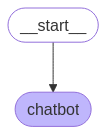

In [ ]:
from IPython.display import Image, display

Image(chat_graph.get_graph().draw_mermaid_png())

In [ ]:
from pprint import pprint

user_msg = "Hello, what can you do?"
state = chat_graph.invoke({"messages": [user_msg]})

# The state object contains lots of information. Uncomment the pprint lines to see it all.
# pprint(state)

# Note that the final state now has 2 messages. Our HumanMessage, and an additional AIMessage.
for msg in state["messages"]:
    print(f"{type(msg).__name__}: {msg.content}")

HumanMessage: Hello, what can you do?
AIMessage: Hi there! I'm EccoBot, your personal e-commerce assistant. I can help you find the perfect products based on what you need. Just tell me what you're looking for, and I'll provide recommendations.


In [ ]:
user_msg = "Oh great, do you know about Google pixel 6A?"

state["messages"].append(user_msg)
state = chat_graph.invoke(state)

# pprint(state)
for msg in state["messages"]:
    print(f"{type(msg).__name__}: {msg.content}")

HumanMessage: Hello, what can you do?
AIMessage: Hi there! I'm EccoBot, your personal e-commerce assistant. I can help you find the perfect products based on what you need. Just tell me what you're looking for, and I'll provide recommendations.
HumanMessage: Oh great, do you know any new iphones?
AIMessage: ```tool_code
get_recommendations(key_word='iPhone')
```
HumanMessage: Oh great, do you know about Google pixel 6A?
AIMessage: ```tool_code
get_recommendations(key_word='Google Pixel 6A')
```


In [ ]:
from langchain_core.messages.ai import AIMessage


def human_node(state: SessionState) -> SessionState:
    """Display the last model message to the user, and receive the user's input."""
    last_msg = state["messages"][-1]
    print("Model:", last_msg.content)

    user_input = input("User: ")

    # If it looks like the user is trying to quit, flag the conversation
    # as over.
    if user_input in {"q", "quit", "exit", "goodbye"}:
        state["finished"] = True

    return state | {"messages": [("user", user_input)]}

def chatbot_with_welcome_msg(state: SessionState) -> SessionState:
    """The chatbot itself. A wrapper around the model's own chat interface."""

    if state["messages"]:
        # If there are messages, continue the conversation with the Gemini model.
        new_output = llm.invoke([ECCOBOT_SYSINT] + state["messages"])
    else:
        # If there are no messages, start with the welcome message.
        new_output = AIMessage(content=WELCOME_MSG)

    return state | {"messages": [new_output]}


# Start building a new graph.
graph_builder = StateGraph(SessionState)

# Add the chatbot and human nodes to the app graph.
graph_builder.add_node("chatbot", chatbot_with_welcome_msg)
graph_builder.add_node("human", human_node)

# Start with the chatbot again.
graph_builder.add_edge(START, "chatbot")

# The chatbot will always go to the human next.
graph_builder.add_edge("chatbot", "human");



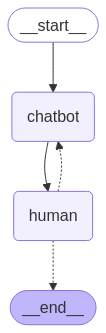

In [ ]:
from typing import Literal


def maybe_exit_human_node(state: SessionState) -> Literal["chatbot", "__end__"]:
    """Route to the chatbot, unless it looks like the user is exiting."""
    if state.get("finished", False):
        return END
    else:
        return "chatbot"


graph_builder.add_conditional_edges("human", maybe_exit_human_node)

chat_with_human_graph = graph_builder.compile()

Image(chat_with_human_graph.get_graph().draw_mermaid_png())

In [ ]:
config = {"recursion_limit": 100}
state = chat_with_human_graph.invoke({"messages": []}, config)

Model: Welcome to Recco. Type `q` to quit. How may I help you today?
User: what can you do?
Model: I can help you discover products based on your needs and preferences. Just tell me what you're looking for, and I'll provide recommendations. For example, you can ask me about 'Nike shoes' or 'iPhone'.
User: show me iphones
Model: ```tool_code
get_recommendations(key_word='iPhone')
```
User: q


In [ ]:
from typing import Annotated, Literal
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage, AIMessage, HumanMessage
from langchain_core.tools import tool
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
import json

# --- Tool Definition ---
class ProductSearchArgs(BaseModel):
    key_word: str = Field(description="A keyword or phrase representing the type of product the user is searching for", json_schema_extra={"type": "string"})

@tool(args_schema=ProductSearchArgs)
def get_recommendations(key_word: str) -> str:
    """
    Fetches product recommendations based on a given keyword or phrase.
    """
    result = recommend_from_local(key_word)
    return result

import json
# import google.generativeai as genai  # Make sure you have this import at the top

def recommend_from_local(key_word: str) -> str:
    # Right now, we are hard coding the contents, later we can add the actual method call from here, which return the JSON.
    products_json_raw = products_dict()

    # # Filter products based on the key_word (case-insensitive)
    # filtered_products = [
    #     p for p in products_json_raw
    #     if key_word.lower() in p["product_name"].lower()
    #        or key_word.lower() in p.get("category", "").lower()
    #        or key_word.lower() in p.get("sub_category", "").lower()
    # ]

    products_json_string = json.dumps(products_json_raw)

    prompt = f"""You are a helpful shopping assistant. You will be provided with a JSON containing details of up to 5 products
retrieved based on a user's query. The json contains relevant products fetched from the database based on user query.
Your task is to process this JSON and present the information in a user-friendly format.
For each product, please provide a concise summary highlighting its key features and explain why it might be relevant to the user's potential needs.

The JSON data for the products will be in the following format:

{products_json_string}
Please process this JSON and output a list of products, as bullets points for each information for given product. Seperate each proudct info with a line
where info about each product includes:

Product Name: (The name of the product)
Summary: (A brief summary of the product, focusing on its main features and benefits.)
Explanation: (A short explanation of why this product might be suitable, considering its category, sub-category, price, and ratings. Compare and contrast these detils with other products)
Link: (The product link)
"""


    client = genai.Client(api_key=GOOGLE_API_KEY)
    answer = client.models.generate_content(
        model="gemini-2.0-flash",
        contents=prompt)
    return answer.text


def products_dict():
  results = [
        {
            "product_name": "iphone 15 pro max 128GB 8GB",
            "price": "$999",
            "number_of_ratings": "2343",
            "category": "Electronics",
            "sub_category": "Smartphones",
            "product_link": "https://www.amazon.com/"
        },
        {
            "product_name": "iphone 16 pro max 256 GB 16 GB",
            "price": "$1199",
            "number_of_ratings": "243",
            "category": "Electronics",
            "sub_category": "Smartphones",
            "product_link": "https://www.amazon.com/"
        },
        {
            "product_name": "google pixel",
            "price": "$999",
            "number_of_ratings": "23",
            "category": "Electronics",
            "sub_category": "Smartphones",
            "product_link": "https://www.amazon.com/"
        },
        {
            "product_name": "samsung galaxy z",
            "price": "$999",
            "number_of_ratings": "233",
            "category": "Electronics",
            "sub_category": "Smartphones",
            "product_link": "https://www.amazon.com/"
        },
        {
            "product_name": "iphone 16 e",
            "price": "$999",
            "number_of_ratings": "2343",
            "category": "Electronics",
            "sub_category": "Smartphones",
            "product_link": "https://www.amazon.com/"
        }
    ]
  print("Hello world")
  return results


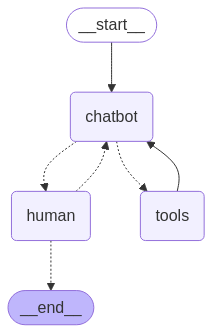

In [ ]:
from langgraph.prebuilt import ToolNode


# Define the tools and create a "tools" node.
tools = [get_recommendations]
tool_node = ToolNode(tools)

# Attach the tools to the model so that it knows what it can call.
llm_with_tools = llm.bind_tools(tools)


def maybe_route_to_tools(state: SessionState) -> Literal["tools", "human"]:
    """Route between human or tool nodes, depending if a tool call is made."""
    if not (msgs := state.get("messages", [])):
        raise ValueError(f"No messages found when parsing state: {state}")

    # Only route based on the last message.
    msg = msgs[-1]

    # When the chatbot returns tool_calls, route to the "tools" node.
    if hasattr(msg, "tool_calls") and len(msg.tool_calls) > 0:
        return "tools"
    else:
        return "human"


def chatbot_with_tools(state: SessionState) -> SessionState:
    """The chatbot with tools. A simple wrapper around the model's own chat interface."""
    defaults = {"finished": False}

    if state["messages"]:
        new_output = llm_with_tools.invoke([ECCOBOT_SYSINT] + state["messages"])
    else:
        new_output = AIMessage(content=WELCOME_MSG)

    # Set up some defaults if not already set, then pass through the provided state,
    # overriding only the "messages" field.
    return defaults | state | {"messages": [new_output]}


graph_builder = StateGraph(SessionState)

# Add the nodes, including the new tool_node.
graph_builder.add_node("chatbot", chatbot_with_tools)
graph_builder.add_node("human", human_node)
graph_builder.add_node("tools", tool_node)

# Chatbot may go to tools, or human.
graph_builder.add_conditional_edges("chatbot", maybe_route_to_tools)
# Human may go back to chatbot, or exit.
graph_builder.add_conditional_edges("human", maybe_exit_human_node)

# Tools always route back to chat afterwards.
graph_builder.add_edge("tools", "chatbot")

graph_builder.add_edge(START, "chatbot")
graph_with_menu = graph_builder.compile()

Image(graph_with_menu.get_graph().draw_mermaid_png())

In [ ]:
state = graph_with_menu.invoke({"messages": []}, config)

Model: Welcome to Recco. Type `q` to quit. How may I help you today?
User: iphones
Hello world
Model: Okay, I found a few iPhones for you:

*   **Product Name:** iphone 15 pro max 128GB 8GB
    *   **Summary:** High-end smartphone with 128GB storage and 8GB RAM, known for its powerful performance and advanced camera capabilities.
    *   **Explanation:** This is a flagship smartphone with a large number of ratings, indicating its popularity. If you're looking for a top-tier iPhone experience, this is a solid option. It's priced at $999, which is standard for premium smartphones.
    *   **Link:** [https://www.amazon.com/](https://www.amazon.com/)

*   **Product Name:** iphone 16 pro max 256 GB 16 GB
    *   **Summary:** The newest phone with larger storage of 256 GB and 16 GB RAM, making it suitable for users who need more storage and even better performance.
    *   **Explanation:** This is the newest phone with the better specs. It is priced at $1199, which is more expensive than the

In [ ]:
from collections.abc import Iterable
from random import randint

from langchain_core.messages.tool import ToolMessage

# These functions have no body; LangGraph does not allow @tools to update
# the conversation state, so you will implement a separate node to handle
# state updates. Using @tools is still very convenient for defining the tool
# schema, so empty functions have been defined that will be bound to the LLM
# but their implementation is deferred to the order_node.
class AddToOrderArgs(BaseModel):
    product: str = Field(..., description="The product to add to the order")
    quantity: int = Field(1, description = "Number of units to add")

@tool(args_schema=AddToOrderArgs)
def add_to_order(product: str, quantity: int = 1) -> str:
    """Adds the specified product to the customer's order,and the quantity.
    By default, the quantity is assumed to be 1.

    Returns:
      The updated order in progress.
    """

@tool
def confirm_order() -> str:
    """Asks the customer if the order is correct.

    Returns:
      The user's free-text response.
    """
@tool
def get_order() -> str:
    """Returns the users order so far. One item per line."""

@tool
def clear_order():
    """Removes all items from the user's order."""

# tool
# def modify_order(product: str):
#     """Removes given product from the user's order.
#     """

class RemoveProductArgs(BaseModel):
    product: str = Field(..., description="The product to remove from the order")

@tool(args_schema=RemoveProductArgs)
def remove_item_from_order(product: str) -> str:
  """
    Returns the updated order after removing the product
  """

class PlaceOrderArgs(BaseModel):
    address: str = Field(..., description="The address to which the order to be shipped to")

@tool(args_schema=PlaceOrderArgs)
def place_order(address: str) -> int:
    """Sends the order to the warehouse for fulfillment and the items
    are delivered to given address.

    Returns:
      The estimated number of days until the order is delivered.
    """

def order_node(state: SessionState) -> SessionState:
    """The ordering node. This is where the order state is manipulated."""
    tool_msg = state.get("messages", [])[-1]
    order = state.get("order", [])
    # order = state.get("order", [])
    outbound_msgs = []
    order_placed = False

    for tool_call in tool_msg.tool_calls:
      if tool_call["name"] == "add_to_order":
        product = tool_call['args']['product']
        quantity = tool_call['args'].get('quantity', 1)
        order.append(f'{product}:{quantity}')
        # order[product]=quantity
        response = "\n".join(order)

      elif tool_call["name"] == "confirm_order":
        print("Your order:")
        if not order:
          print("  (no items)")

        for drink in order:
          print(f"  {drink}")

        response = input("Is this correct? ")

      elif tool_call["name"] == "get_order":
        response = "\n".join(order) if order else "(no order)"

      elif tool_call["name"] == "clear_order":
        order.clear()
        response = None

      elif tool_call["name"] == "remove_item_from_order":
        product = tool_call["args"]["product"]
        order = [item for item in order if product.lower() not in item.lower()]
        response = "\n".join(order)

      elif tool_call["name"] == "place_order":
        order_text = "\n".join(order)
        print("Sending order to the Warehouse!")
        print(order_text)

        order_placed = True
        eta_days = randint(2,7) #ETA in days
      # elif tool_call["name"] == "update_order":
        response = (
        f"✅ Your order has been placed!\n"
        f"🕒 Estimated delivery: {eta_days} day{'s' if eta_days > 1 else ''}.\n\n"
        "📦 Would you like to order anything else?"
    )

      else:
        raise NotImplementedError(f'Unknown tool call: {tool_call["name"]}')

      outbound_msgs.append(
            ToolMessage(
                content=response,
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )
    return {"messages": outbound_msgs, "order": order, "finished": order_placed}

def maybe_route_to_tools(state: SessionState) -> str:
    """Route between chat and tool nodes if a tool call is made."""
    if not (msgs := state.get("messages", [])):
        raise ValueError(f"No messages found when parsing state: {state}")

    msg = msgs[-1]

    if state.get("finished", False):
        # When an order is placed, exit the app. The system instruction indicates
        # that the chatbot should say thanks and goodbye at this point, so we can exit
        # cleanly.
        return END

    elif hasattr(msg, "tool_calls") and len(msg.tool_calls) > 0:
        # Route to `tools` node for any automated tool calls first.
        if any(
            tool["name"] in tool_node.tools_by_name.keys() for tool in msg.tool_calls
        ):
            return "tools"
        else:
            return "ordering"

    else:
        return "human"

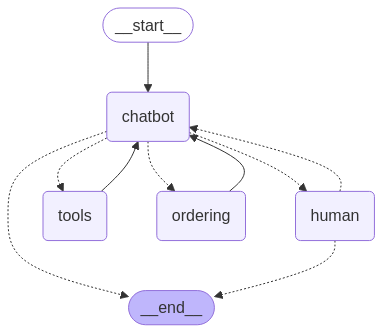

In [ ]:
# Auto-tools will be invoked automatically by the ToolNode
auto_tools = [get_recommendations]
tool_node = ToolNode(auto_tools)

# Order-tools will be handled by the order node.
order_tools = [add_to_order, confirm_order, get_order, clear_order, place_order, remove_item_from_order ]

# The LLM needs to know about all of the tools, so specify everything here.
llm_with_tools = llm.bind_tools(auto_tools + order_tools)


graph_builder = StateGraph(SessionState)

# Nodes
graph_builder.add_node("chatbot", chatbot_with_tools)
graph_builder.add_node("human", human_node)
graph_builder.add_node("tools", tool_node)
graph_builder.add_node("ordering", order_node)

# Chatbot -> {ordering, tools, human, END}
graph_builder.add_conditional_edges("chatbot", maybe_route_to_tools)
# Human -> {chatbot, END}
graph_builder.add_conditional_edges("human", maybe_exit_human_node)

# Tools (both kinds) always route back to chat afterwards.
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("ordering", "chatbot")

graph_builder.add_edge(START, "chatbot")
graph_with_order_tools = graph_builder.compile()

Image(graph_with_order_tools.get_graph().draw_mermaid_png())

In [ ]:
state = graph_with_order_tools.invoke({"messages": []}, config)

Model: Welcome to Recco. Type `q` to quit. How may I help you today?
Hello world
Model: Here are some iPhones that I found for you:

*   **Product Name:** iPhone 15 Pro Max 128GB 8GB
    *   **Summary:** Apple's flagship iPhone 15 Pro Max, featuring 128GB of storage and 8GB of RAM, known for its powerful performance and advanced camera system.
    *   **Explanation:** This is a solid, well-rated option if you're already in the Apple ecosystem or prefer iOS. It offers ample storage and RAM for most users. The high number of ratings (2343) suggests it's a popular and generally well-received choice. At $999, it is similarly priced to other phones in the list but has more ratings.
    *   **Link:** [https://www.amazon.com/](https://www.amazon.com/)

*   **Product Name:** iPhone 16 Pro Max 256 GB 16 GB
    *   **Summary:** This is the next generation of iPhones, with double the storage and RAM compared to the iPhone 15 Pro Max.
    *   **Explanation:** If you need extra storage and better p

In [ ]:
pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 5.0 MB/s eta 0:00:00


In [ ]:
import gradio as gr
from langchain_core.messages import HumanMessage, AIMessage

# Setup complete session state (must match SessionState structure)
chat_state = {
    "messages": [],
    "order": [],
    "finished": False
}

def run_eccobot(user_input):
    try:
        # Add user message
        chat_state["messages"].append(HumanMessage(content=user_input))

        # Run the LangGraph agent
        updated_state = graph_with_order_tools.invoke({
            "messages": chat_state["messages"],
            "order": chat_state["order"],
            "finished": chat_state["finished"]
        })

        # Extract the latest AI message
        response = ""
        for msg in reversed(updated_state["messages"]):
            if isinstance(msg, AIMessage):
                response = msg.content
                break

        # Update full session state
        chat_state["messages"] = updated_state["messages"]
        chat_state["order"] = updated_state.get("order", [])
        chat_state["finished"] = updated_state.get("finished", False)

        # If the session ended
        if chat_state["finished"]:
            chat_state["messages"] = []
            chat_state["order"] = []
            chat_state["finished"] = False
            response += "\n\n✅ Order placed. Start a new one anytime!"

        return response

    except Exception as e:
        import traceback
        return f"❌ Error:\n```\n{traceback.format_exc()}\n```"

# Gradio Interface (for Colab)
gr.ChatInterface(
    fn=run_eccobot,
    chatbot=gr.Chatbot(label="🛒 EccoBot - Order Assistant"),
    textbox=gr.Textbox(placeholder="Ask about iPhones, place order, etc.", scale=7),
    title="🤖 EccoBot (LangGraph + Gradio)",
    description="Your shopping companion. Ask about products, manage your cart, and place orders.",
    theme="soft"
).launch(share=True)


<ipython-input-77-257628726e96>:51: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot=gr.Chatbot(label="🛒 EccoBot - Order Assistant"),
/usr/local/lib/python3.11/dist-packages/gradio/chat_interface.py:321: UserWarning: The gr.ChatInterface was not provided with a type, so the type of the gr.Chatbot, 'tuples', will be used.
  warnings.warn(


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://4642baa49fc1982c8d.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
